# Linefit Deep Ensemble

## The dataset: simple linefit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
## first, import all the necessary modules
import arviz as az
import corner
import graphviz
import jax
from jax import random
import jax.numpy as jnp # yes i know this is confusing
import matplotlib.pyplot as plt
import numpy as np

## in numpyro, you must specify number of sampling chains you will use upfront

# words of wisdom from Tian Li and crew:
# on gpu, don't use conda, use pip install
# HMC after SBI to look at degeneracies between params
# different guides (some are slower but better at showing degeneracies)

import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [3]:
import sys
sys.path.append('..')
from src.scripts import train, models, analysis

In [4]:
loss_type = 'var_loss'
# options are 'no_var_loss' or 'var_loss'

## Generate line data
To do this make a dataframe and replicate a bunch of columns. There are 8 pendulums on two different planets. The planet_id and pendulum_id are integers denoting which pendulum and which planet each row of the dataframe belongs.

In [5]:
def simulator(thetas):#, percent_errors):
    # just plop the pendulum within here
    m, b, sigma = thetas
    x = np.linspace(0, 100, 101)
    rs = np.random.RandomState()#2147483648)# 
    ε = rs.normal(loc=0, scale=sigma, size = len(x)) 
    return m * x + b + ε

In [6]:
length_df = 1000
#ms = np.zeros((length_df, 101))
ms = np.zeros((length_df, 101))
bs = np.zeros((length_df, 101))
sigmas = np.zeros((length_df, 101))
xs = np.zeros((length_df, 101))
ys = []
#true_sigmas = []

for r in range(length_df):
    rs = np.random.RandomState()#2147483648)# 
    m = rs.normal(loc=1, scale=1)
    b = rs.normal(loc=0, scale=10)
    sigma = abs(rs.normal(loc=0, scale=10))
    thetas_1d = [m, b, sigma]
    xs[r,:] = np.linspace(0, 100, 101)
    ms[r,:] = np.repeat(thetas_1d[0], 101)
    bs[r,:] = np.repeat(thetas_1d[1], 101)
    sigmas[r,:] = np.repeat(thetas_1d[2], 101)
    
    ys.append(simulator(thetas_1d))

<Figure size 640x480 with 0 Axes>

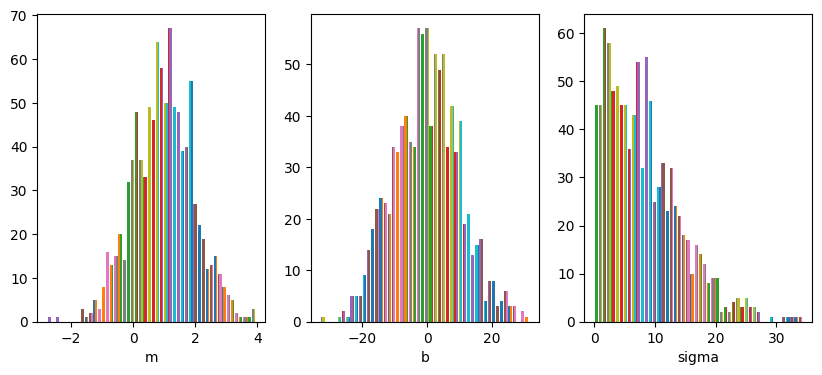

In [7]:
plt.clf()
fig = plt.figure(figsize = (10,4))
ax1 = fig.add_subplot(131)
ax1.hist(ms, bins=50)
ax1.set_xlabel('m')
ax2 = fig.add_subplot(132)
ax2.hist(bs, bins=50)
ax2.set_xlabel('b')
ax3 = fig.add_subplot(133)
ax3.hist(sigmas, bins=50)
ax3.set_xlabel('sigma')
plt.show()

In [8]:
print(np.shape(ms))
print(np.shape(xs))
print(np.shape(ys))

(1000, 101)
(1000, 101)
(1000, 101)


In [9]:
# so I'd actually like for there to be four input nodes
# and each one to have 1000 x 101 data points

In [10]:
# stack the xs and the parameters so we can have a 4x101 input
# so that each data point is 101 units long
inputs = np.stack([xs, ms, bs, sigmas], axis = (2))
inputs_flatten = np.reshape(inputs, (1000 * 101, 4))
print(np.shape(inputs))
print(np.shape(inputs_flatten))

# also change ys:
ys_flatten = np.reshape(ys, (1000 * 101, ))

(1000, 101, 4)
(101000, 4)


In [11]:
# okay so the order is xs, ms, bs, sigmas
print(inputs_flatten)
print(ys_flatten)

[[  0.           0.20666295   4.28818693   1.3260793 ]
 [  1.           0.20666295   4.28818693   1.3260793 ]
 [  2.           0.20666295   4.28818693   1.3260793 ]
 ...
 [ 98.           1.04842159  -2.6153273    2.19697059]
 [ 99.           1.04842159  -2.6153273    2.19697059]
 [100.           1.04842159  -2.6153273    2.19697059]]
[  3.60909695   4.24706307   3.43352928 ... 103.97881252 100.68033814
 101.36844416]


In [12]:
# we need to normalize everything
inputmin = np.min(inputs_flatten, axis = 0)
inputmax = np.max(inputs_flatten, axis = 0)#, axis = 0)
outputmin = np.min(ys_flatten)
outputmax = np.max(ys_flatten)

norm_inputs = (inputs_flatten - inputmin) / (inputmax - inputmin)
norm_outputs = (ys_flatten - outputmin) / (outputmax - outputmin)

<Figure size 640x480 with 0 Axes>

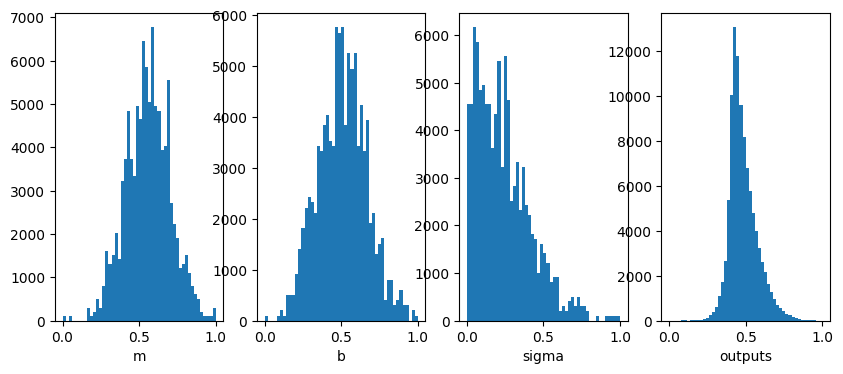

In [13]:
plt.clf()
fig = plt.figure(figsize = (10,4))
ax1 = fig.add_subplot(141)
ax1.hist(norm_inputs[:,1], bins=50)
ax1.set_xlabel('m')
ax2 = fig.add_subplot(142)
ax2.hist(norm_inputs[:,2], bins=50)
ax2.set_xlabel('b')
ax3 = fig.add_subplot(143)
ax3.hist(norm_inputs[:,3], bins=50)
ax3.set_xlabel('sigma')
ax4 = fig.add_subplot(144)
ax4.hist(norm_outputs[:], bins=50)
ax4.set_xlabel('outputs')
plt.show()

In [14]:
## Awesome, they are now normalized 0 - 1 but have the same distribution as before

(90900, 4) (90900,)
(4,)


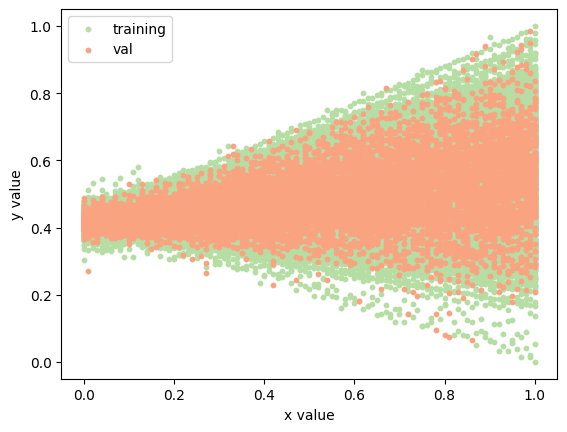

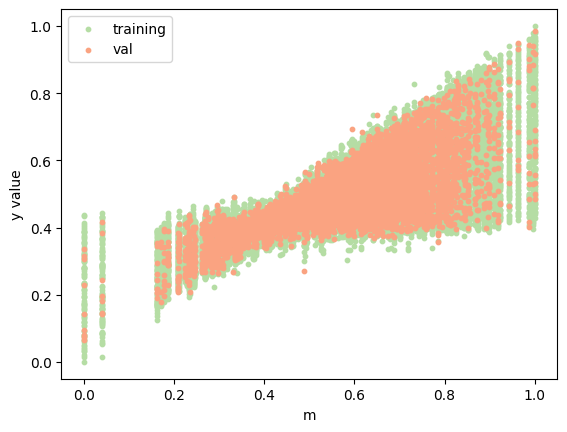

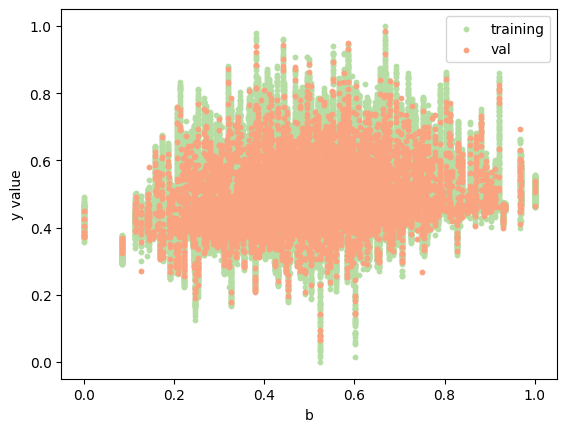

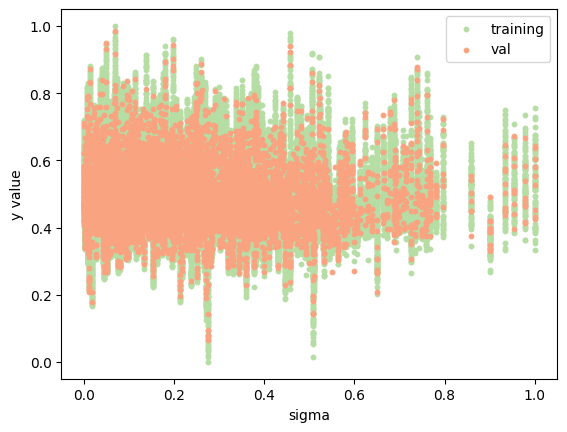

'\nSTOP\n#\n\nscaler = StandardScaler()\nscaler.fit(data)\nStandardScaler()\n>>> print(scaler.mean_)\n[0.5 0.5]\n>>> print(scaler.transform(data))\n\nx_scaler, x_train, x_val = StandardScaler(x_train, x_val)\ny_scaler, y_train, y_val = StandardScaler(y_train, y_val)\n'

In [15]:
# prepare the training, validation, and test set split:

val_proportion = 0.1
x_train, x_val, y_train, y_val = train_test_split(norm_inputs, norm_outputs, test_size=val_proportion, random_state=42)

print(np.shape(x_train), np.shape(y_train))
print(np.shape(x_train[:][0]))


plt.clf()
plt.scatter(x_train[:,0], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,0], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('x value')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,1], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,1], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('m')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,2], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,2], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('b')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,3], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,3], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('sigma')
plt.ylabel('y value')
plt.show()



'''
STOP
#

scaler = StandardScaler()
scaler.fit(data)
StandardScaler()
>>> print(scaler.mean_)
[0.5 0.5]
>>> print(scaler.transform(data))

x_scaler, x_train, x_val = StandardScaler(x_train, x_val)
y_scaler, y_train, y_val = StandardScaler(y_train, y_val)
'''

In [16]:
# okay now train the thing
BATCH_SIZE = 128

# add a dimension so that xs have a one channel input
#x_train = x_train.reshape(x_train.shape[0], 1) # 1 was the middle dimension
#x_val = x_val.reshape(x_val.shape[0], 1)

'''
print('y', np.shape(y_train))
print('x', np.shape(x_train))
STOP
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]) # 1 was the middle dimension
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1])
#x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[1])
'''

trainData = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
trainDataLoader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)

valData = TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

print('shape of training set', np.shape(x_train))

shape of training set (90900, 4)


In [17]:
# initialize the simple model
INIT_LR = 0.001
print("[INFO] initializing the gal model...")
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


if loss_type == 'no_var_loss':
    model = models.de_no_var().to(device)
    # initialize our optimizer and loss function
    opt = torch.optim.Adam(model.parameters(), lr=INIT_LR)
    lossFn = torch.nn.MSELoss(reduction="mean")
else:
    model = models.de_var().to(device)
    # initialize our optimizer and loss function
    opt = torch.optim.Adam(model.parameters(), lr=INIT_LR)
    lossFn = torch.nn.GaussianNLLLoss(full=False, eps=1e-06, reduction="mean")
#nn.MSELoss(reduction = "mean")

[INFO] initializing the gal model...


In [18]:
print(model)

de_var(
  (ln_1): Linear(in_features=4, out_features=100, bias=True)
  (act1): ReLU()
  (drop1): Dropout(p=0.1, inplace=False)
  (ln_2): Linear(in_features=100, out_features=100, bias=True)
  (act2): ReLU()
  (drop2): Dropout(p=0.1, inplace=False)
  (ln_3): Linear(in_features=100, out_features=100, bias=True)
  (act3): ReLU()
  (drop3): Dropout(p=0.1, inplace=False)
  (ln_4): Linear(in_features=100, out_features=2, bias=True)
)


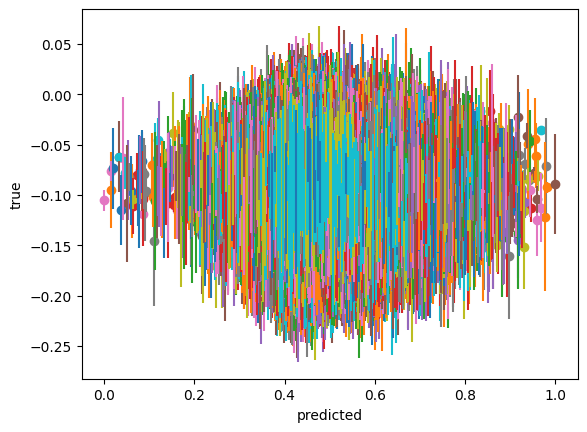

In [19]:
# plot what we're trying to predict
counter = 0
for (x, y) in trainDataLoader: # loading it up in batches
    #print('batch', counter, 'length', len(y))
    # send the input to the device
    (x, y) = (x.to(device), y.to(device))
    pred_tensor = model(x)
    pred = pred_tensor.detach().numpy()
    #print(y.shape, pred.shape)
    
    if loss_type == 'no_var_loss':
        print(np.shape(y), np.shape(pred))
        plt.scatter(y, pred, linestyle='None')
        #var = torch.ones(5, 1, requires_grad=True)  # homoscedastic
        #print('var', pred[:,1])
        loss = lossFn(pred_tensor, y)
        #print('loss', loss.item())
    else:
        plt.errorbar(y, pred[:,0], yerr = abs(pred[:,1]), linestyle='None')
        plt.scatter(y, pred[:,0], linestyle='None')
        #var = torch.ones(5, 1, requires_grad=True)  # homoscedastic
        #print('var', pred[:,1])
        loss = lossFn(pred_tensor[:,0], y, pred_tensor[:,1]**2)
        #print('loss', loss.item())
    
    counter += 1
plt.xlabel('predicted')
plt.ylabel('true')
#plt.xlim([0,1])
#plt.ylim([0,1])
plt.show()
# Interesting, before the model is trained it basically predicts the mean?

[INFO] training the network...
saving checkpoints?
False
starting here 0
epoch 0 0.0


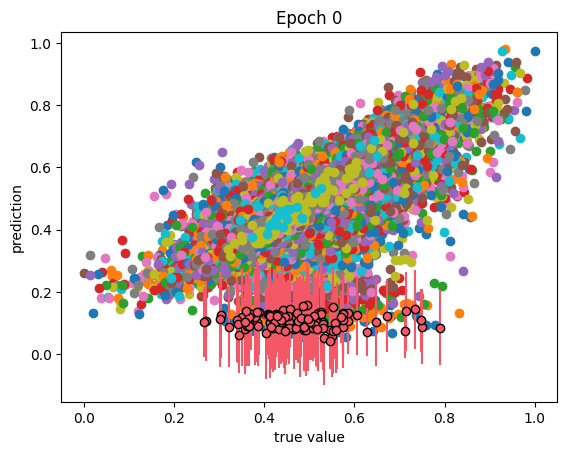

new best mse -3.4623312950134277 in epoch 0
epoch 1 0.0
new best mse -3.6032116413116455 in epoch 1
epoch 2 0.01
new best mse -3.7556183338165283 in epoch 2
epoch 3 0.01
epoch 4 0.01
new best mse -3.84030818939209 in epoch 4
epoch 5 0.01


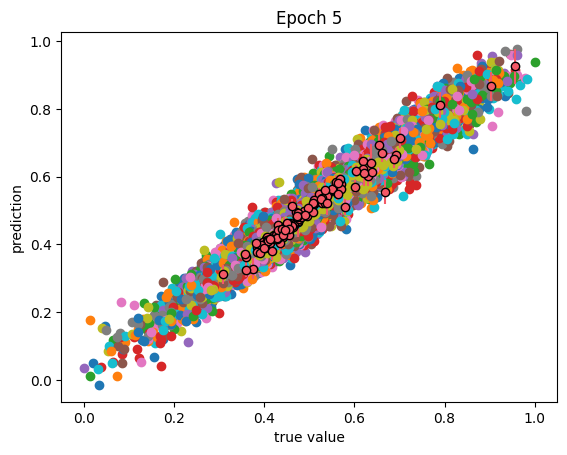

new best mse -3.898447275161743 in epoch 5
epoch 6 0.01
epoch 7 0.02
epoch 8 0.02
epoch 9 0.02
epoch 10 0.03


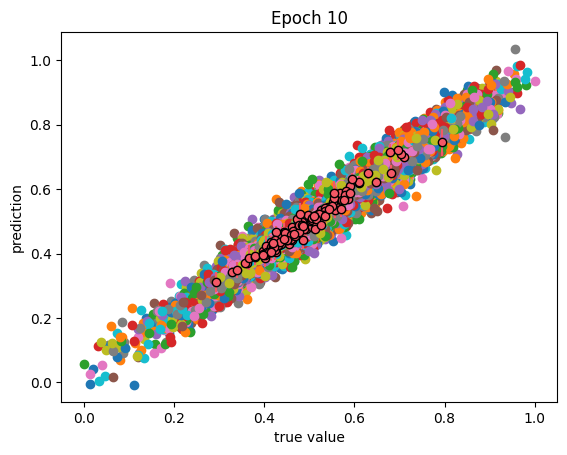

epoch 11 0.03
epoch 12 0.03
epoch 13 0.03
epoch 14 0.04
epoch 15 0.04


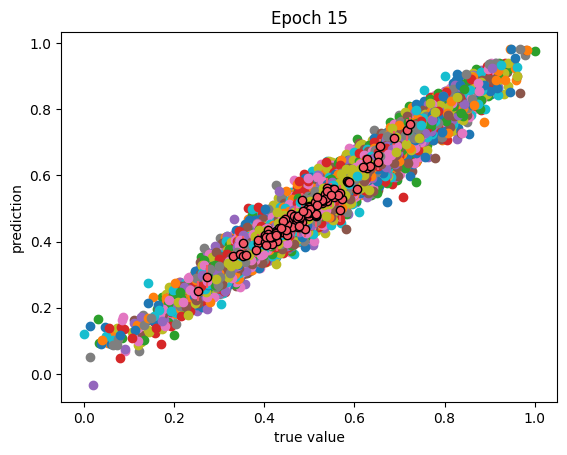

epoch 16 0.04
epoch 17 0.04
epoch 18 0.04
epoch 19 0.05
epoch 20 0.05


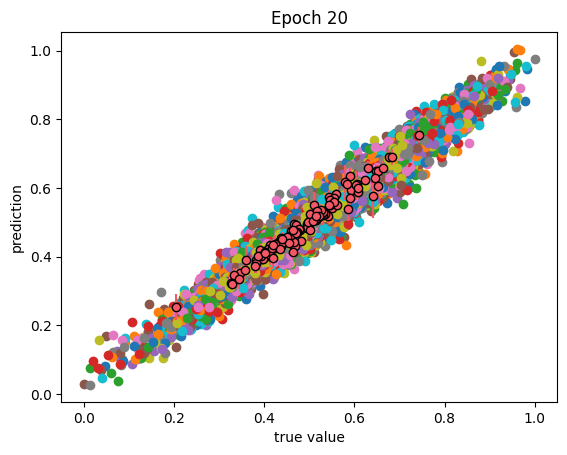

epoch 21 0.05
epoch 22 0.06
epoch 23 0.06
epoch 24 0.06
epoch 25 0.06


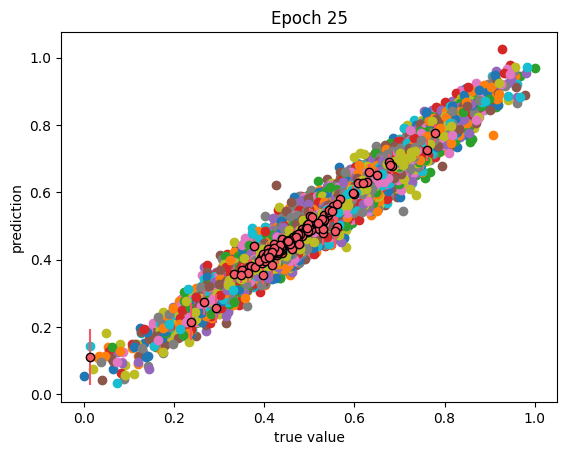

epoch 26 0.07
epoch 27 0.07
epoch 28 0.07
epoch 29 0.07
epoch 30 0.07


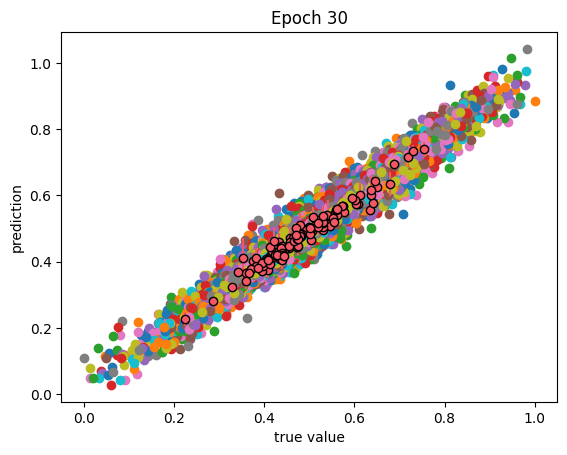

epoch 31 0.08
epoch 32 0.08
epoch 33 0.08
epoch 34 0.09
epoch 35 0.09


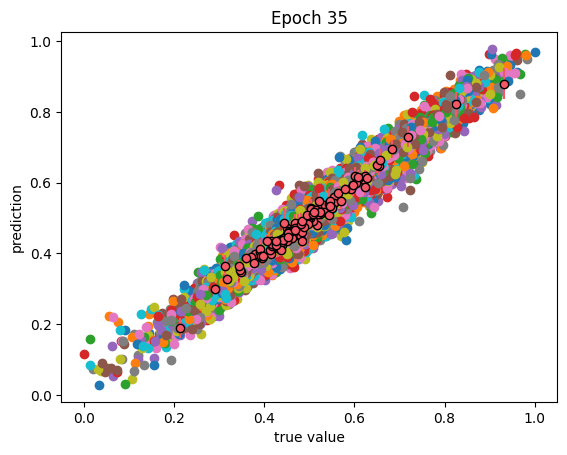

epoch 36 0.09
epoch 37 0.09
epoch 38 0.1
epoch 39 0.1
epoch 40 0.1


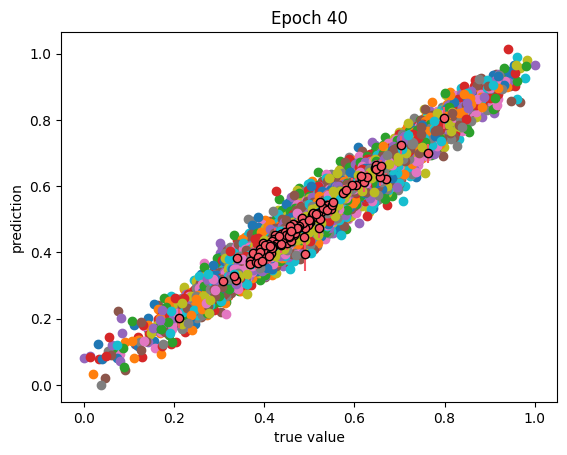

epoch 41 0.1
epoch 42 0.1
epoch 43 0.11
epoch 44 0.11
epoch 45 0.11


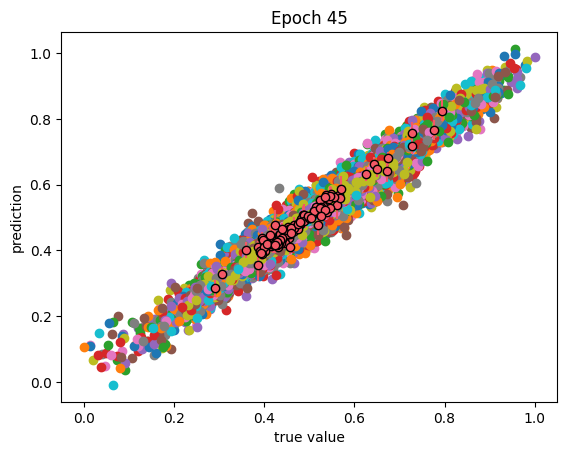

epoch 46 0.12
epoch 47 0.12
epoch 48 0.12
epoch 49 0.12
epoch 50 0.12


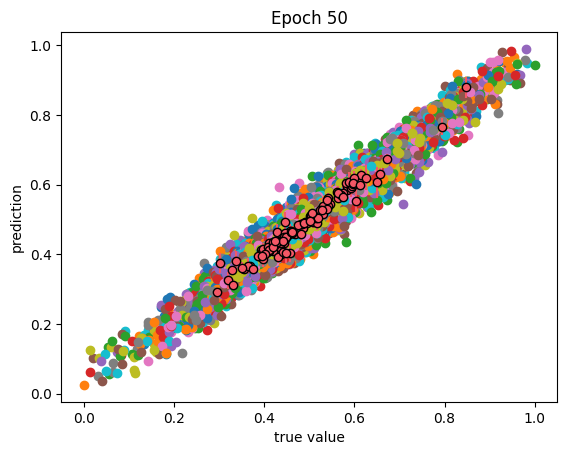

epoch 51 0.13
epoch 52 0.13
epoch 53 0.13
epoch 54 0.14
epoch 55 0.14


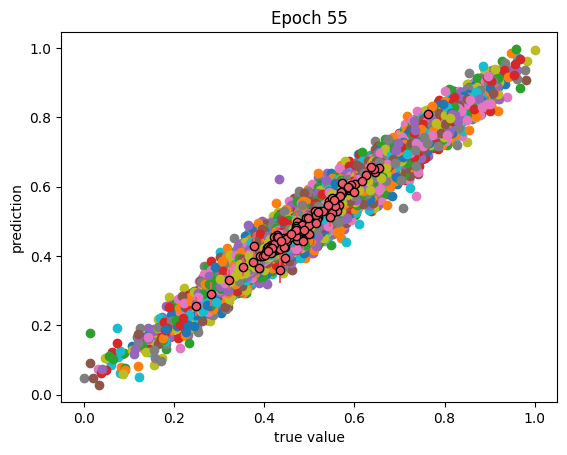

epoch 56 0.14
epoch 57 0.14
epoch 58 0.14
epoch 59 0.15
epoch 60 0.15


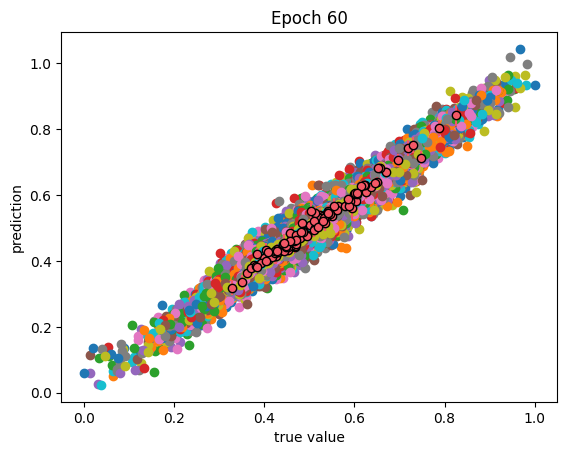

epoch 61 0.15
epoch 62 0.15
epoch 63 0.16
epoch 64 0.16
epoch 65 0.16


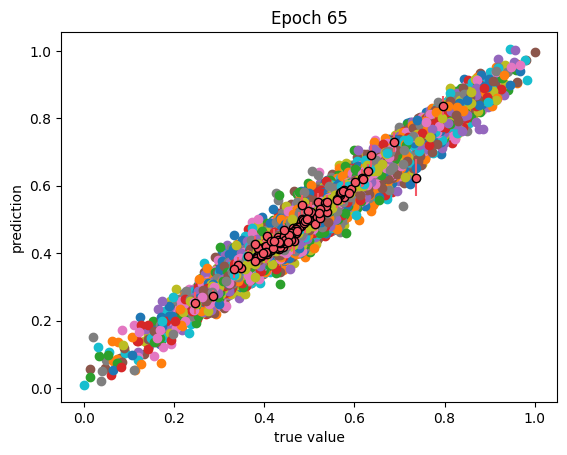

epoch 66 0.17
epoch 67 0.17
epoch 68 0.17
epoch 69 0.17
epoch 70 0.17


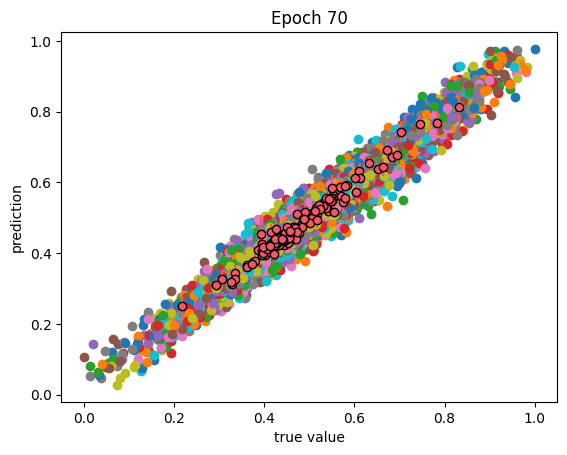

epoch 71 0.18
epoch 72 0.18
epoch 73 0.18
epoch 74 0.18
epoch 75 0.19


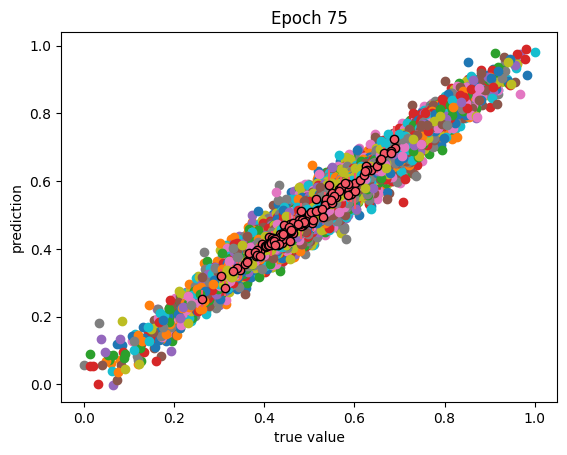

epoch 76 0.19
epoch 77 0.19
epoch 78 0.2
epoch 79 0.2
epoch 80 0.2


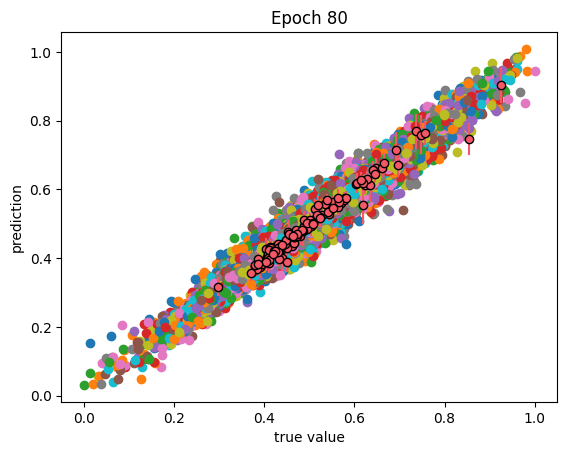

epoch 81 0.2
epoch 82 0.2
epoch 83 0.21
epoch 84 0.21
epoch 85 0.21


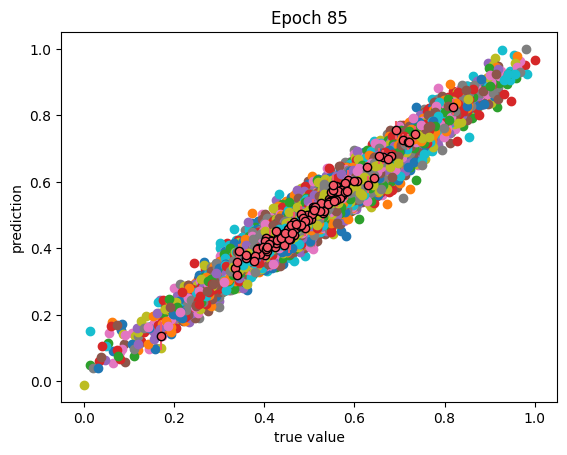

epoch 86 0.21
epoch 87 0.22
epoch 88 0.22
epoch 89 0.22
epoch 90 0.23


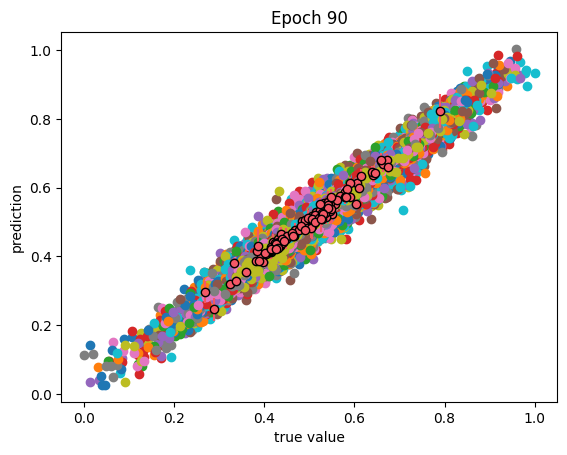

epoch 91 0.23
epoch 92 0.23
epoch 93 0.23
epoch 94 0.23
epoch 95 0.24


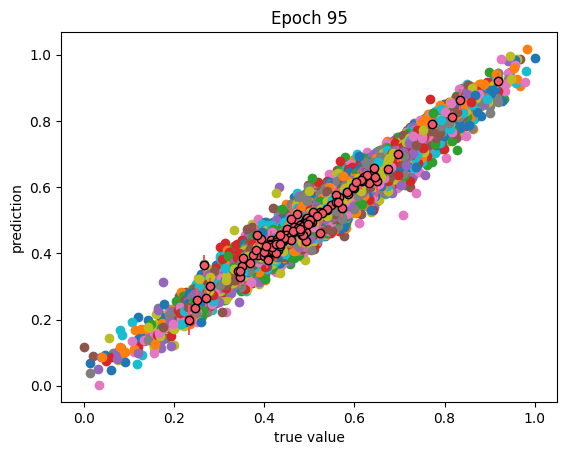

epoch 96 0.24
epoch 97 0.24
epoch 98 0.24
epoch 99 0.25
epoch 100 0.25


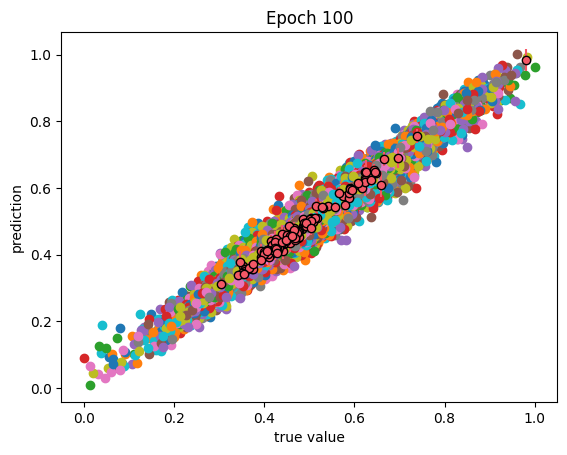

epoch 101 0.25
epoch 102 0.26
epoch 103 0.26
epoch 104 0.26
epoch 105 0.26


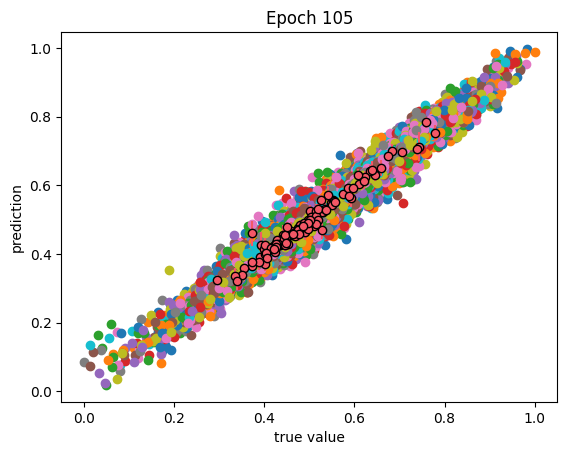

epoch 106 0.27
epoch 107 0.27
epoch 108 0.27
epoch 109 0.27
epoch 110 0.28


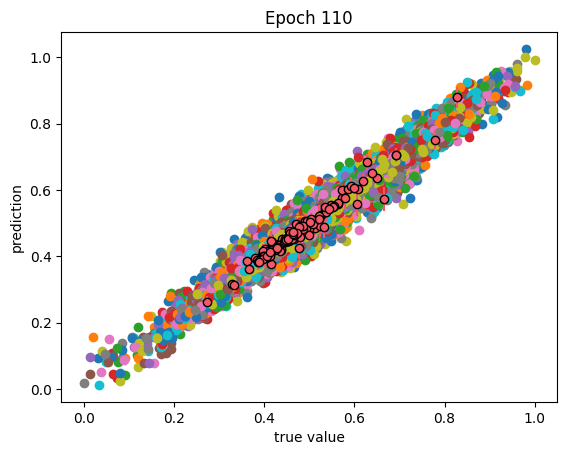

epoch 111 0.28
epoch 112 0.28
epoch 113 0.28
epoch 114 0.28
epoch 115 0.29


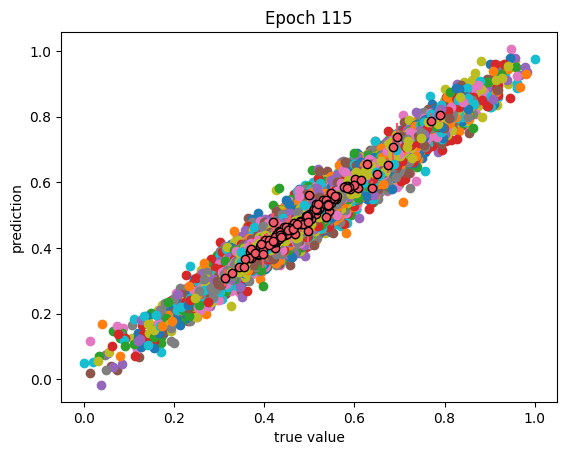

epoch 116 0.29
epoch 117 0.29
epoch 118 0.29
epoch 119 0.3
epoch 120 0.3


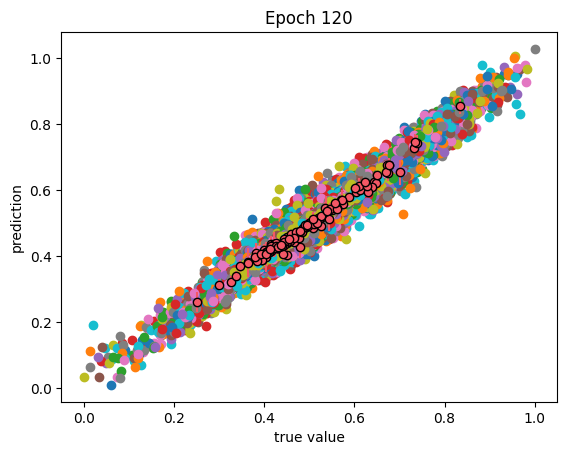

epoch 121 0.3
epoch 122 0.3
epoch 123 0.31
epoch 124 0.31
epoch 125 0.31


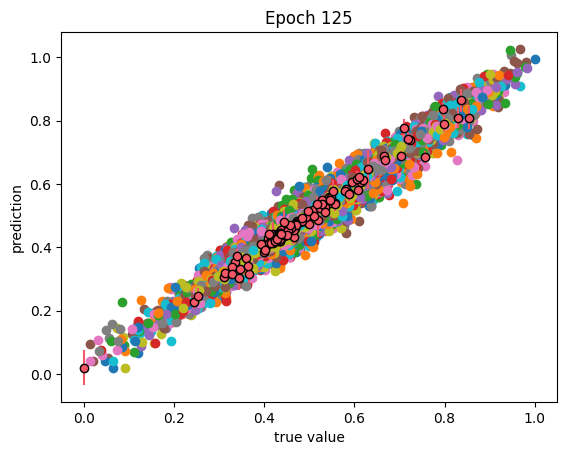

epoch 126 0.32
epoch 127 0.32
epoch 128 0.32
epoch 129 0.32
epoch 130 0.33


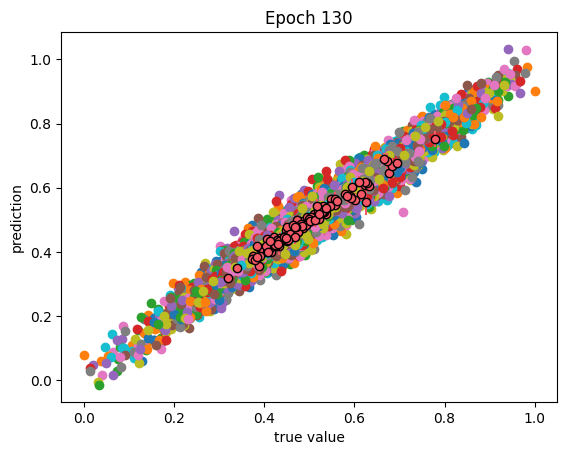

epoch 131 0.33
epoch 132 0.33
epoch 133 0.33
epoch 134 0.34
epoch 135 0.34


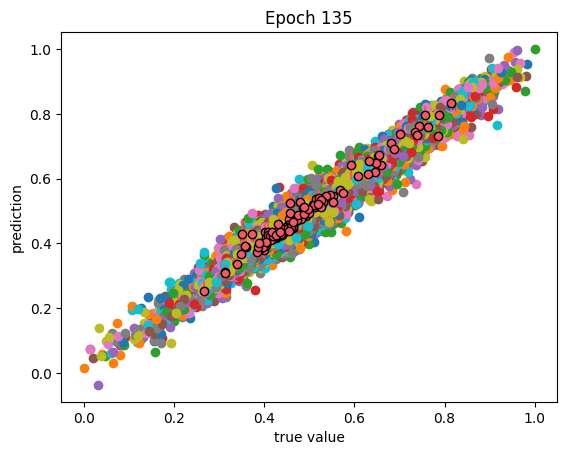

epoch 136 0.34
epoch 137 0.34
epoch 138 0.34
epoch 139 0.35
epoch 140 0.35


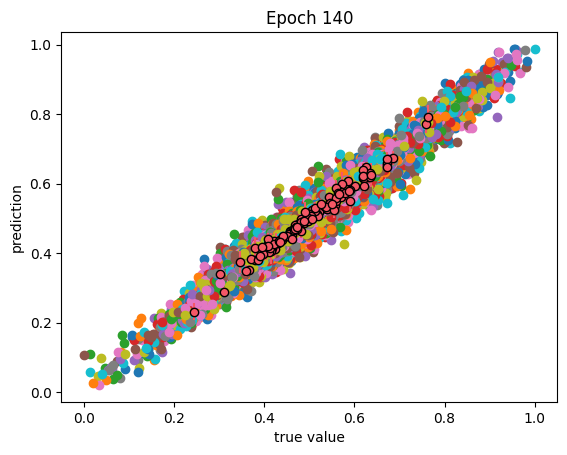

epoch 141 0.35
epoch 142 0.35
epoch 143 0.36
epoch 144 0.36
epoch 145 0.36


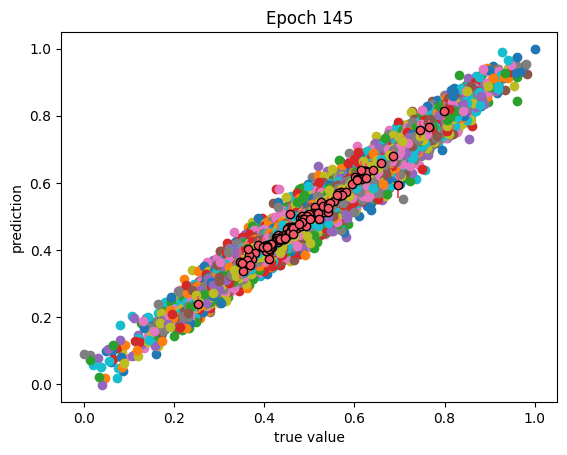

epoch 146 0.36
epoch 147 0.37
epoch 148 0.37
epoch 149 0.37
epoch 150 0.38


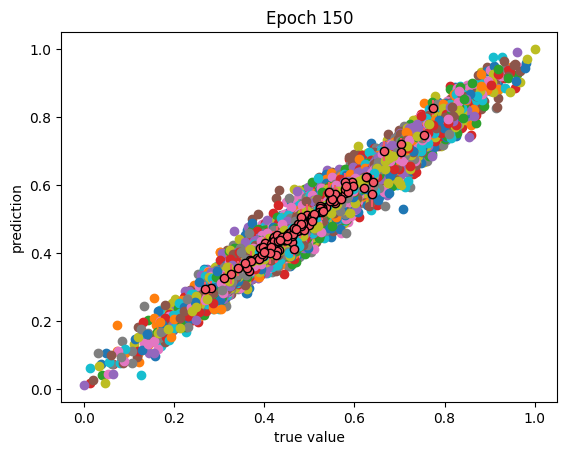

epoch 151 0.38
epoch 152 0.38
epoch 153 0.38
epoch 154 0.39
epoch 155 0.39


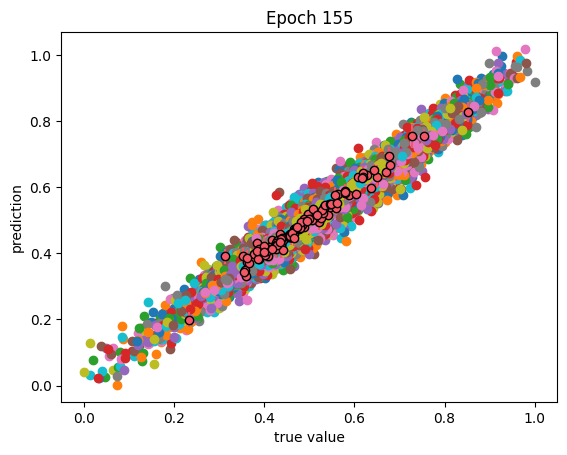

epoch 156 0.39
epoch 157 0.39
epoch 158 0.4
epoch 159 0.4
epoch 160 0.4


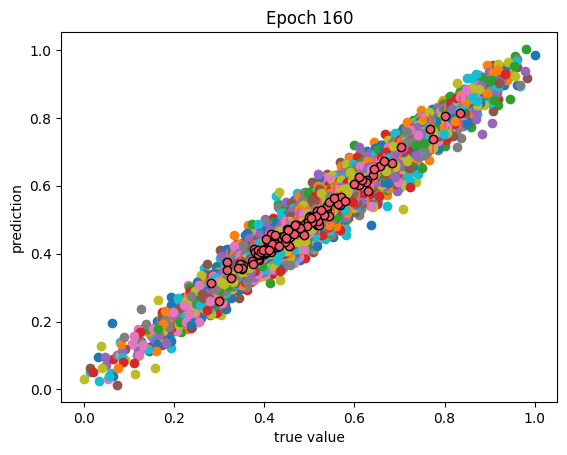

epoch 161 0.4
epoch 162 0.41
epoch 163 0.41
epoch 164 0.41
epoch 165 0.41


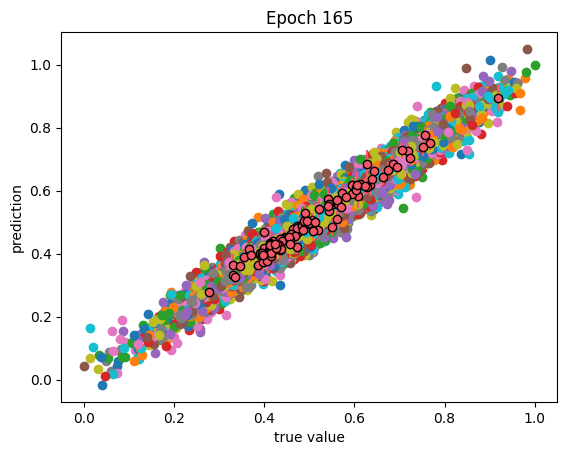

epoch 166 0.41
epoch 167 0.42
epoch 168 0.42
epoch 169 0.42
epoch 170 0.42


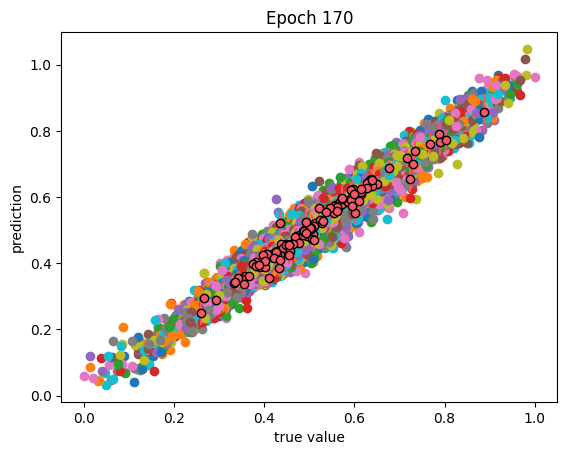

epoch 171 0.43
epoch 172 0.43
epoch 173 0.43
epoch 174 0.43
epoch 175 0.44


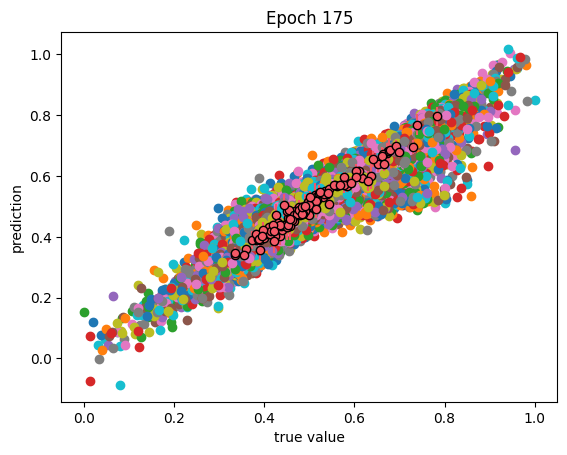

epoch 176 0.44
epoch 177 0.44
epoch 178 0.45
epoch 179 0.45
epoch 180 0.45


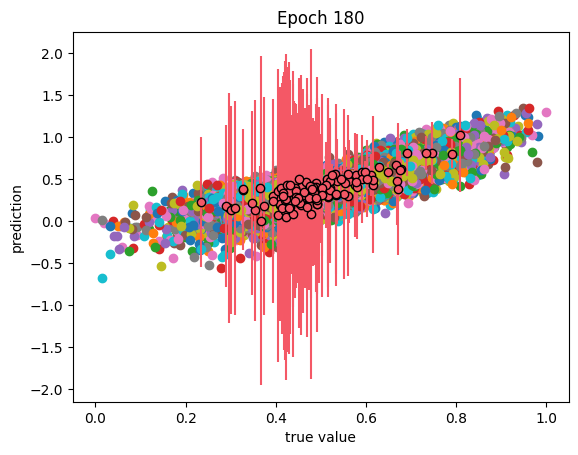

epoch 181 0.45
epoch 182 0.46
epoch 183 0.46
epoch 184 0.46
epoch 185 0.46


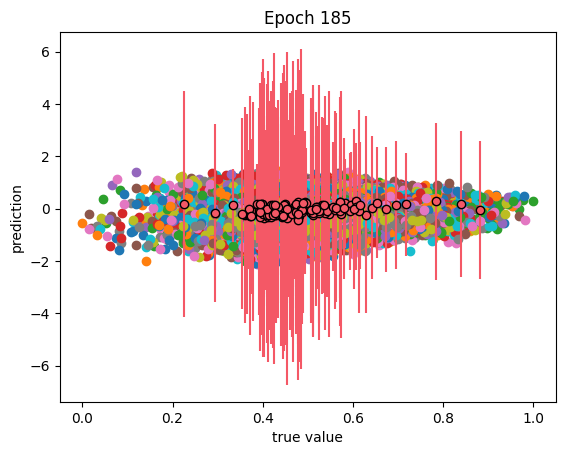

epoch 186 0.47
epoch 187 0.47
epoch 188 0.47
epoch 189 0.47
epoch 190 0.47


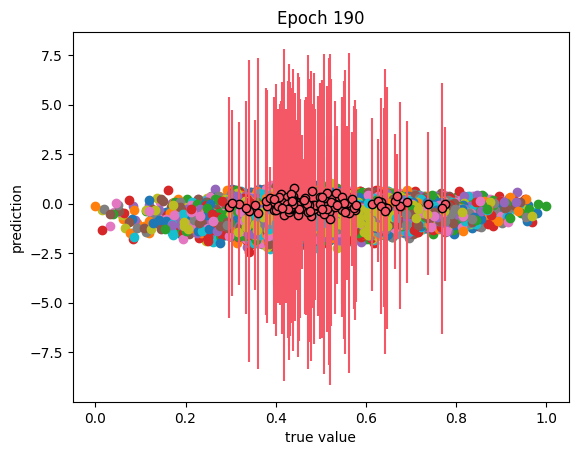

epoch 191 0.48
epoch 192 0.48
epoch 193 0.48
epoch 194 0.48
epoch 195 0.49


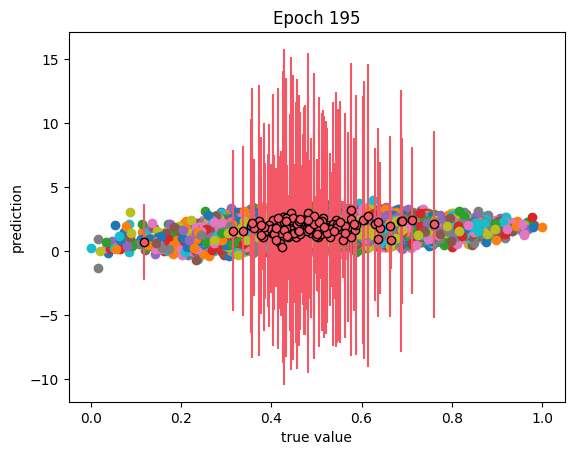

epoch 196 0.49
epoch 197 0.49
epoch 198 0.49
epoch 199 0.5
epoch 200 0.5


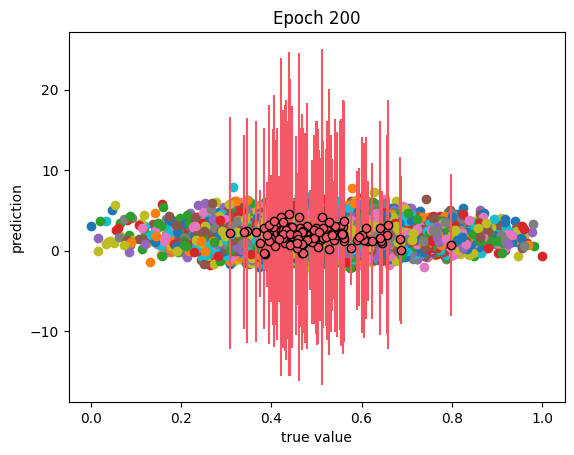

epoch 201 0.5
epoch 202 0.51
epoch 203 0.51
epoch 204 0.51
epoch 205 0.51


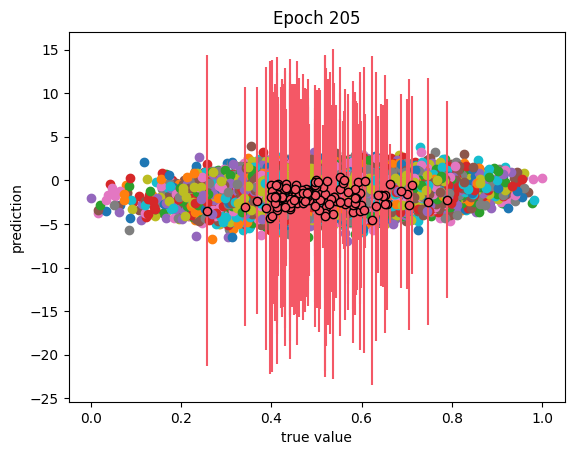

epoch 206 0.52
epoch 207 0.52
epoch 208 0.52
epoch 209 0.52
epoch 210 0.53


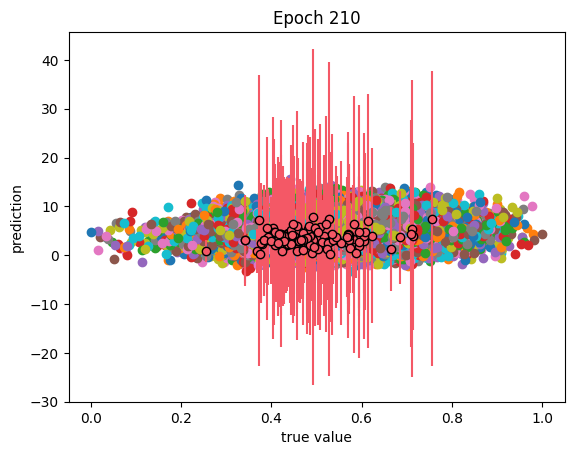

epoch 211 0.53
epoch 212 0.53
epoch 213 0.53
epoch 214 0.54
epoch 215 0.54


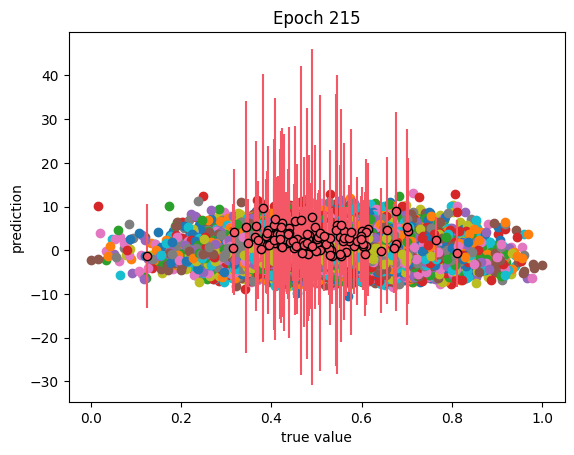

epoch 216 0.54
epoch 217 0.54
epoch 218 0.55
epoch 219 0.55
epoch 220 0.55


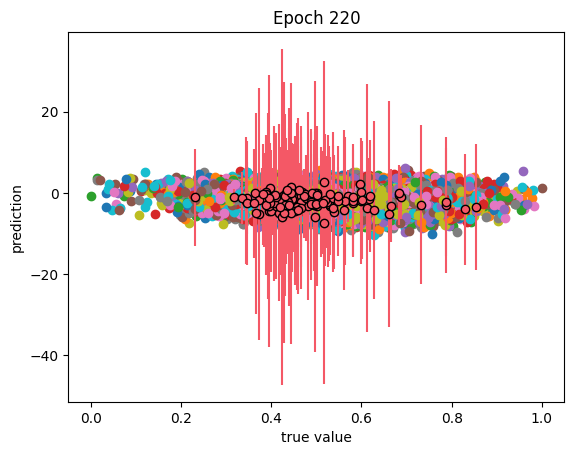

epoch 221 0.55
epoch 222 0.56
epoch 223 0.56
epoch 224 0.56


In [ ]:
n_models = 2
model_ensemble = train.train_DE(trainDataLoader,
             x_val,
             y_val,
             INIT_LR,
             device,
             loss_type,
             n_models,
             model_name='DE',
             EPOCHS=400,
             save_checkpoints=False,
             plot=True)
 

In [ ]:
# plot the "posterior" plot, which is gonna be a Gaussian
# for each individual data point
print(np.shape(x_val), np.shape(y_val))
print(x_val[0], y_val[0])
# is there a way to convert x_val[0][3] back to its true value?
# og_value = normal_value * (xmax - xmin) + xmin
og_xval = x_val[0] * (xmax - xmin) + xmin
print('og_xval', og_xval)
og_yval = y_val[0] * (ymax - ymin) + ymin
print('og_yval', og_yval)
STOP
color_list = ['#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360']

for m in range(n_models):
    model = model_ensemble[m]
    model.eval()
    y_pred = model(torch.Tensor(x_val[0]))
    print(y_pred)
    STOP
    y_pred_list.append(y_pred[:,0].detach().numpy())
    

In [ ]:
# there's gotta be a good way to plot the x and the y
plt.clf()

color_list = ['#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360']
y_pred_list = []
for m in range(n_models):
    print(m)
    
        
    
    model = model_ensemble[m]
    model.eval()
    y_pred = model(torch.Tensor(x_val))
    y_pred_list.append(y_pred[:,0].detach().numpy())
    if m > 0:
        continue

    if loss_type == 'no_var_loss':
        plt.scatter(x_val[:,1], y_pred.detach().numpy(),
                label = 'predicted', s = 10, color = 'black')#color = color_list[m],
    else:
        plt.scatter(x_val[:,1], y_pred[:,0].detach().numpy(),
                label = f'predicted model {m}', color = 'black', ls = 'None')#color = color_list[m],
        plt.errorbar(x_val[:,1], y_pred[:,0].detach().numpy(),
                     yerr = abs(y_pred[:,1].detach().numpy()),
                label = f'predicted var model {m}', color = 'black', ls = 'None')#color = color_list[m],
    
dx_dtheta = analysis.calc_error_prop(x_val[:,0], x_val[:,1], x_val[:,2], 0.1, time = 0.5, wrt = 'theta_0')
#print(dx_dtheta)
plt.scatter(x_val[:,1], y_val, label = 'actual', color = 'red', s = 10)
plt.errorbar(x_val[:,1], y_val, yerr = dx_dtheta, label = 'actual', color = 'red', ls = 'None')

plt.xlabel('theta')
plt.ylabel('x pos')
plt.legend()
plt.show()

## Now epistemic error

In [ ]:
#print(y_pred_list)
#print(np.mean(y_pred_list, axis = 0))

plt.clf()
plt.scatter(x_val[:,1], np.mean(y_pred_list, axis = 0), label = 'predicted mean', color = 'black')
plt.errorbar(x_val[:,1], np.mean(y_pred_list, axis = 0),
             yerr = np.std(y_pred_list, axis = 0),
             label = 'predicted std', color = 'black',
             ls = 'None')
dx_dtheta = analysis.calc_error_prop(x_val[:,0], x_val[:,1], x_val[:,2], 0.1, time = 0.5, wrt = 'theta_0')
#print(dx_dtheta)
plt.scatter(x_val[:,1], y_val, label = 'actual', color = 'red', s = 10)
plt.errorbar(x_val[:,1], y_val, yerr = dx_dtheta, label = 'actual analytic expectation', color = 'red', ls = 'None')
plt.xlabel('theta')
plt.ylabel('x pos')
plt.legend()
plt.show()

In [ ]:
plt.clf()
plt.scatter(x_val[:,3], np.mean(y_pred_list, axis = 0), label = 'predicted mean', color = 'black')
plt.errorbar(x_val[:,3], np.mean(y_pred_list, axis = 0),
             yerr = np.std(y_pred_list, axis = 0),
             label = 'predicted std', color = 'black',
             ls = 'None')
plt.scatter(x_val[:,3], y_val, label = 'actual', color = 'red', s = 10)
#plt.errorbar(x_val[:,3], y_val, yerr = dx_dtheta, label = 'actual analytic expectation', color = 'red', ls = 'None')
plt.xlabel('epsilon')
plt.ylabel('x pos')
plt.legend()
plt.show()

In [ ]:
# there's gotta be a good way to plot the x and the y
plt.clf()

y_pred_list_array = np.zeros((np.shape(x_val)[0], n_models))
for m in range(n_models):
    model = model_ensemble[m]
    model.eval()
    y_pred = model(torch.Tensor(x_val))
    y_pred_list_array[:,m] = y_pred.detach().numpy().flatten()

sort_indices = np.argsort(x_val[:, 1])
x_val_sorted = x_val[sort_indices]
y_pred_list_sorted = y_pred_list_array[sort_indices]    
medians = np.median(y_pred_list_sorted, axis = 1).flatten()
mins = np.min(y_pred_list_sorted, axis = 1).flatten()
maxes = np.max(y_pred_list_sorted, axis = 1).flatten()

#plt.fill_between(x_val_sorted[:,1],
#                 mins,
#                 maxes,
#                 label = 'predicted')#color = color_list[m],
plt.errorbar(x_val_sorted[:,1], medians,
             yerr = [medians - mins,maxes - medians], linestyle = 'None', capsize = 5, color = 'black')

plt.scatter(x_val[:,1], y_val, label = 'actual', color = 'red', s = 10)

plt.xlabel('theta')
plt.ylabel('x pos')
plt.legend()
plt.show()

In [ ]:
# also go through and plot the error prop uncertainty given x_val
plt.clf()



y_pred_list_array = np.zeros((np.shape(x_val)[0], n_models))
for m in range(n_models):
    model = model_ensemble[m]
    model.eval()
    y_pred = model(torch.Tensor(x_val))
    y_pred_list_array[:,m] = y_pred.detach().numpy().flatten()

sort_indices = np.argsort(x_val[:, 1])
x_val_sorted = x_val[sort_indices]
y_pred_list_sorted = y_pred_list_array[sort_indices]    
medians = np.median(y_pred_list_sorted, axis = 1).flatten()
mins = np.min(y_pred_list_sorted, axis = 1).flatten()
maxes = np.max(y_pred_list_sorted, axis = 1).flatten()

#plt.fill_between(x_val_sorted[:,1],
#                 mins,
#                 maxes,
#                 label = 'predicted')#color = color_list[m],
plt.errorbar(x_val_sorted[:,1], medians,
             yerr = [medians - mins,maxes - medians], linestyle = 'None', capsize = 5, color = 'black',
             label = 'prediction')

plt.scatter(x_val[:,1], y_val, label = 'actual', color = 'red', s = 10)
plt.errorbar(x_val[:,1], y_val,
             yerr = calc_error_prop(x_val[:,0], x_val[:,1], x_val[:,2], percent_error * x_val[:,1], time = 0.5, wrt = 'theta_0'),
             color = 'red', ls = 'None', capsize = 5)


plt.xlabel('theta')
plt.ylabel('x pos')
plt.legend()
plt.show()

In [ ]:
analysis.calc_error_prop(x_val[:,0], x_val[:,1], x_val[:,2], percent_error * x_val[:,1], time = 0.5, wrt = 'theta_0')